# PCA (Principal Component Analysis) / APC (Analyse en Composantes Principales)


PCA (or APC in French) is a **statistical** technique used to reduce the number of variables in a dataset while keeping as much information **(variance)** as possible.

It transforms the original variables into **new uncorrelated variables** called **principal components**, which summarize the main patterns in the data.

In this notebook, we will perform a Principal Component Analysis (PCA) on a dataset that contains information about different **car models**. The dataset contains specifications of various car models, including their **performance and design features.** Each row represents a car model, and each column provides a specific characteristic of that car.
### Dataset Features

| Feature | Description |
|----------|-------------|
| **model** | Name of the car model |
| **mpg** | Miles per gallon — fuel efficiency of the car |
| **cyl** | Number of cylinders in the engine |
| **disp** | Displacement (in cubic inches) — engine size |
| **hp** | Horsepower — engine power |
| **drat** | Rear axle ratio |
| **wt** | Weight of the car (in 1000 lbs) |
| **qsec** | Quarter mile time — time required to cover a quarter mile (performance indicator) |
| **vs** | Engine shape (0 = V-shaped, 1 = straight) |
| **am** | Transmission type (0 = automatic, 1 = manual) |
| **gear** | Number of forward gears |
| **carb** | Number of carburetors |



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import cholesky

# Configuration pour de beaux graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
df = pd.read_csv("./mtcars.csv")
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [7]:
df.dtypes

model     object
mpg      float64
cyl        int64
disp     float64
hp         int64
drat     float64
wt       float64
qsec     float64
vs         int64
am         int64
gear       int64
carb       int64
dtype: object

In [8]:
# Select numeric columns
num_feat = df.select_dtypes(include=['float64', 'int64'])

# Display correlation matrix
corr_matrix = num_feat.corr()
print(corr_matrix)

           mpg       cyl      disp        hp      drat        wt      qsec  \
mpg   1.000000 -0.852162 -0.847551 -0.776168  0.681172 -0.867659  0.418684   
cyl  -0.852162  1.000000  0.902033  0.832447 -0.699938  0.782496 -0.591242   
disp -0.847551  0.902033  1.000000  0.790949 -0.710214  0.887980 -0.433698   
hp   -0.776168  0.832447  0.790949  1.000000 -0.448759  0.658748 -0.708223   
drat  0.681172 -0.699938 -0.710214 -0.448759  1.000000 -0.712441  0.091205   
wt   -0.867659  0.782496  0.887980  0.658748 -0.712441  1.000000 -0.174716   
qsec  0.418684 -0.591242 -0.433698 -0.708223  0.091205 -0.174716  1.000000   
vs    0.664039 -0.810812 -0.710416 -0.723097  0.440278 -0.554916  0.744535   
am    0.599832 -0.522607 -0.591227 -0.243204  0.712711 -0.692495 -0.229861   
gear  0.480285 -0.492687 -0.555569 -0.125704  0.699610 -0.583287 -0.212682   
carb -0.550925  0.526988  0.394977  0.749812 -0.090790  0.427606 -0.656249   

            vs        am      gear      carb  
mpg   0.664039  

# STEP 1: Identifying Relationships between Variables

We will display the **correlation matrix** of the dataset in the form of a **heatmap**, allowing us to visualize the relationships between numerical variables.

---

#### 🧩 Purpose
The goal of this function is to:
- Measure how strongly variables are related to one another  
- Identify patterns of positive or negative correlations  
- Detect potential redundancy between variables before performing PCA  


📊 This visualization helps determine which variables move together and which are independent, this is an important step before applying **Principal Component Analysis (PCA)**.


In [10]:
def analyser_correlations(df, title="Correlation Matrix"):
    """
    Affiche la matrice de corrélation du dataset.
    """
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap="BrBG", 
                center=0, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Statistiques de corrélation
    corr_values = corr.values[np.triu_indices_from(corr.values, k=1)]
    print(f"\nStatistiques des corrélations :")
    print(f"  Moyenne : {np.mean(np.abs(corr_values)):.3f}")
    print(f"  Médiane : {np.median(np.abs(corr_values)):.3f}")
    print(f"  Max : {np.max(np.abs(corr_values)):.3f}")
    print(f"  Min : {np.min(np.abs(corr_values)):.3f}")


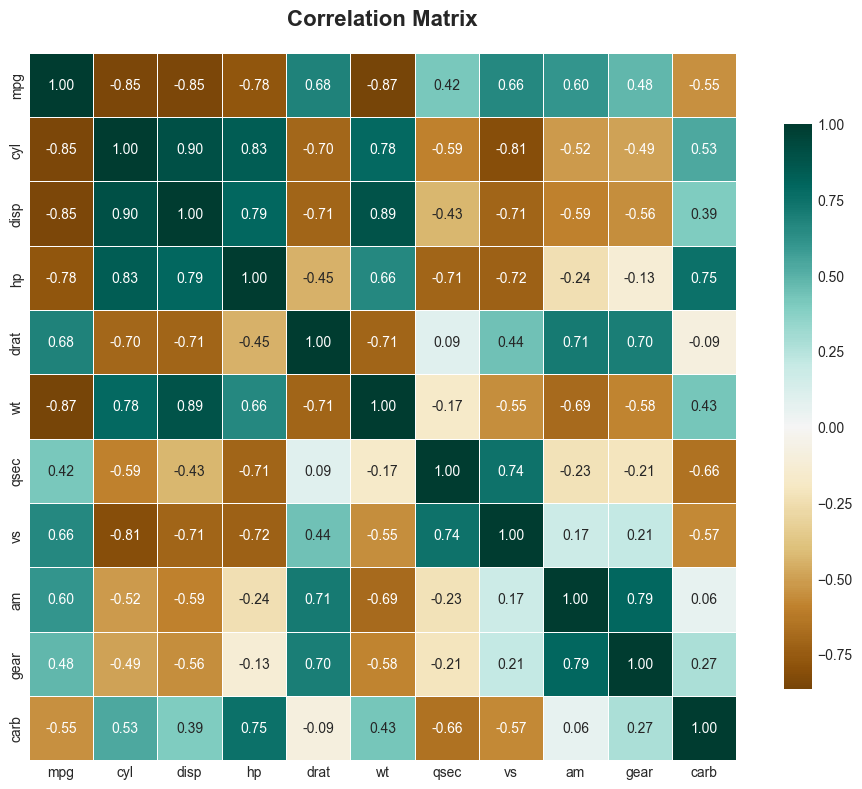


Statistiques des corrélations :
  Moyenne : 0.559
  Médiane : 0.591
  Max : 0.902
  Min : 0.058


In [11]:
analyser_correlations(num_feat, "Correlation Matrix")

### Interpretation

The correlation analysis shows that the dataset contains variables with varying degrees of relationship:  

- **Strong positive correlations:**  
  - `cyl` and `disp` (0.90), `disp` and `wt` (0.89), `hp` and `carb` (0.75) — these indicate that larger engines tend to have more cylinders, higher weight, and more carburetors.  
- **Strong negative correlations:**  
  - `mpg` and `wt` (-0.87), `mpg` and `cyl` (-0.85), `mpg` and `disp` (-0.85) — suggesting that heavier cars and cars with bigger engines tend to be less fuel-efficient.  
- **Moderate correlations:**  
  - Variables like `mpg` and `vs` (0.66) or `drat` and `am` (0.71) show moderate relationships, indicating some patterns in transmission type and engine shape.  
- **Weak correlations:**  
  - Pairs like `am` and `carb` (0.06) or `drat` and `qsec` (0.09) are almost independent, contributing unique information to the dataset.  

So, the dataset shows a mix of strong, moderate, and weak correlations. This suggests that **PCA can reduce dimensionality** effectively, capturing most of the variance while summarizing relationships among variables.


# Step 2: Performing PCA

We will perform **Principal Component Analysis (PCA)** on a dataset and returns the transformed data along with the PCA model and standardized data.

- **Standardize the data**: Ensures all features contribute equally to the analysis, preventing variables with larger scales from dominating.  
- **Reduce dimensionality**: PCA identifies new axes (principal components) that capture the maximum variance in the data.  
- **Simplify and summarize data**: Transforms the original variables into uncorrelated components for easier visualization and analysis.  

#### 🧠 Why Standardization is important
Without standardization, variables with larger scales (e.g., `wt` vs. `hp`) could dominate the PCA, giving misleading results. Standardization ensures each variable contributes proportionally to the analysis.


In [14]:
"""Standardize your data so that all features have the same importance.

Decide how many principal components to keep.

"""

def effectuer_acp(df, n_components=None):
    """
    Effectue une ACP sur le DataFrame.
    
    Retourne :
    - pca : objet PCA fitted
    - X_pca : données transformées
    - X_scaled : données standardisées
    """
    # Standardisation (CRITIQUE pour l'ACP)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # ACP
    if n_components is None:
        n_components = min(df.shape)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca, X_scaled


In [15]:
#ACP
pca, X_pca, X_scaled = effectuer_acp(num_feat)

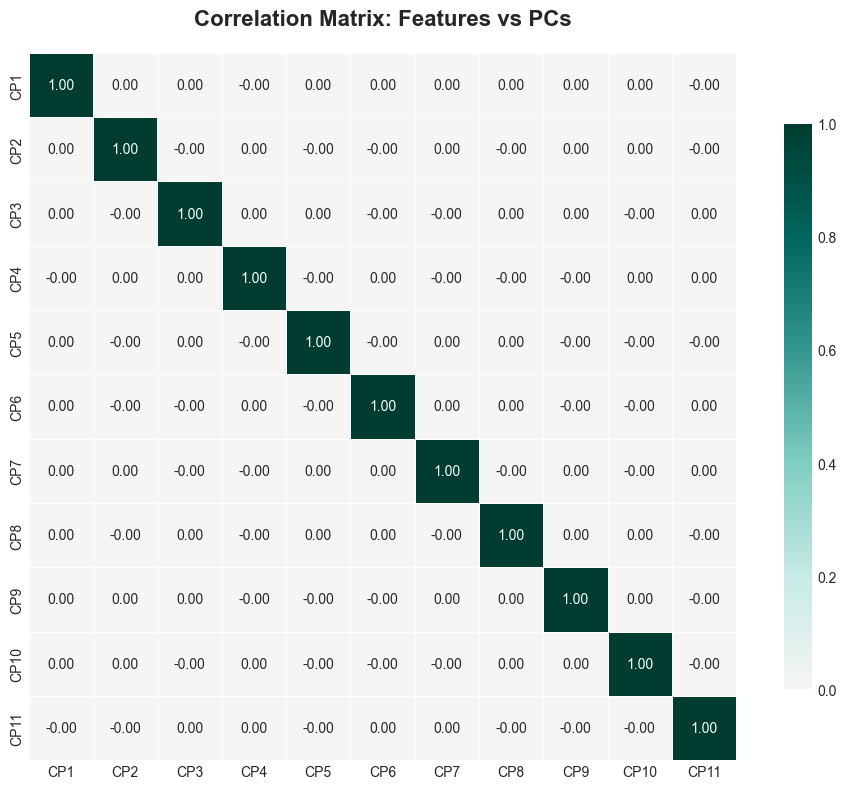


Statistiques des corrélations :
  Moyenne : 0.000
  Médiane : 0.000
  Max : 0.000
  Min : 0.000


In [16]:
# X_scaled: standardized original features
# X_pca_df: projected data on PCs
X_pca_df = pd.DataFrame(X_pca, columns=[f'CP{i+1}' for i in range(X_pca.shape[1])])

# Call your existing function
analyser_correlations(X_pca_df, title="Correlation Matrix: Features vs PCs")


### 📊 Interpretation
 
This indicates that after performing PCA, the principal components are **uncorrelated** with each other **(correlation ≈ 0)**. Each original variable primarily correlates strongly with itself, showing that PCA has effectively captured the main patterns in the data while **removing redundancy between variables**.


# Step 3: Explained Variance Plot

We will visualize the **variance explained by each principal component** after performing PCA. It helps to determine **how many components to keep** for further analysis. This will help :

- Show the **individual contribution** of each principal component to the total variance.  
- Show the **cumulative variance** to decide how many components are sufficient to capture most of the information in the data (e.g., 80–90%).  

- The first few components typically explain **most of the variance**, allowing dimensionality reduction without losing much information.  
- Components beyond the point where cumulative variance stabilizes contribute little new information.

In [57]:
num_feat.shape

(32, 11)

In [19]:
def plot_variance_expliquee(pca, title="Variance Expliquée"):
    """
    Graphique de la variance expliquée par chaque composante.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Variance expliquée par composante
    axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1),
                pca.explained_variance_ratio_ * 100)
    axes[0].set_xlabel('Composante Principale', fontsize=12)
    axes[0].set_ylabel('% Variance Expliquée', fontsize=12)
    axes[0].set_title('Variance Expliquée par Composante', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Variance expliquée cumulée
    variance_cumulee = np.cumsum(pca.explained_variance_ratio_) * 100
    axes[1].plot(range(1, len(variance_cumulee) + 1), variance_cumulee, 
                 marker='o', linewidth=2, markersize=8, color='coral')
    axes[1].axhline(y=80, color='red', linestyle='--', label='Seuil 80%')
    axes[1].set_xlabel('Nombre de Composantes', fontsize=12)
    axes[1].set_ylabel('% Variance Expliquée Cumulée', fontsize=12)
    axes[1].set_title('Variance Expliquée Cumulée', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Afficher les valeurs
    print(f"\n{'Composante':<15} {'% Variance':<15} {'% Cumulé'}")
    print("-" * 45)
    for i, (var, cum) in enumerate(zip(pca.explained_variance_ratio_, variance_cumulee)):
        print(f"CP{i+1:<13} {var*100:>6.2f}%{cum:>18.2f}%")


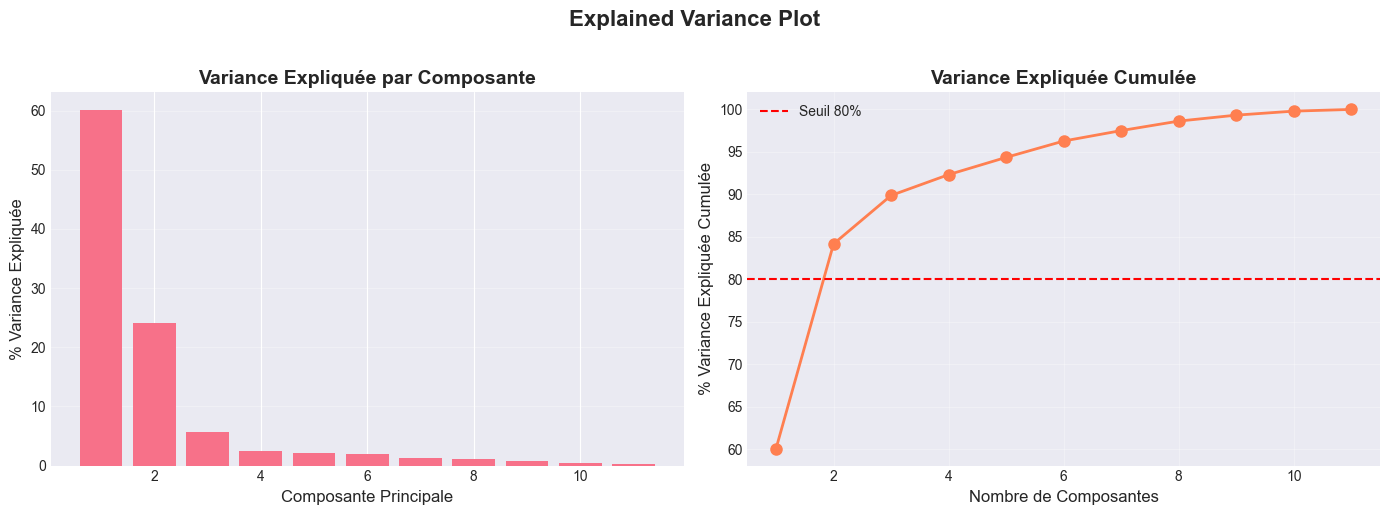


Composante      % Variance      % Cumulé
---------------------------------------------
CP1              60.08%             60.08%
CP2              24.10%             84.17%
CP3               5.70%             89.87%
CP4               2.45%             92.32%
CP5               2.03%             94.36%
CP6               1.92%             96.28%
CP7               1.23%             97.51%
CP8               1.12%             98.63%
CP9               0.70%             99.33%
CP10              0.47%             99.80%
CP11              0.20%            100.00%


In [20]:
# Variance expliquée
plot_variance_expliquee(pca, "Explained Variance Plot")

### 📊 Interpretation

The initial goal was to capture **at least 80% of the variance**, a common threshold in PCA to ensure most of the dataset’s information is retained while reducing dimensionality.  
This is achieved with the **first two principal components (CP1 and CP2)**, which together explain **84.17%** of the total variance.  
The remaining components contribute relatively little, so we will focus on CP1 and CP2 to provide a concise summary for our analysis.


# Step 4: Correlation Circle of Variables

The Correlation Circle of Variables visualizes how the **original variables** are projected onto the **first two principal components (CP1 and CP2)** using a **correlation circle**.  It helps :
- Show the contribution of each variable to the first two principal components.  
- Identify **relationships between variables**:
  - Variables pointing in the same direction are **positively correlated**.  
  - Variables pointing in opposite directions are **negatively correlated**.  
  - Variables at right angles are roughly **uncorrelated**.  


In [23]:
def plot_variables(pca, feature_names, title="Correlation Circle of Variables"):
    """
    Cercle de corrélation des variables.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Dessiner le cercle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linewidth=2)
    ax.add_patch(circle)
    
    # Projeter les variables
    for i, feature in enumerate(feature_names):
        x = pca.components_[0, i]
        y = pca.components_[1, i]
        
        # Dessiner la flèche
        ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, 
                fc='blue', ec='blue', linewidth=2, alpha=0.7)
        
        # Ajouter le label
        ax.text(x * 1.15, y * 1.15, feature, fontsize=11, 
               ha='center', va='center', fontweight='bold')
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel(f'CP1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'CP2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

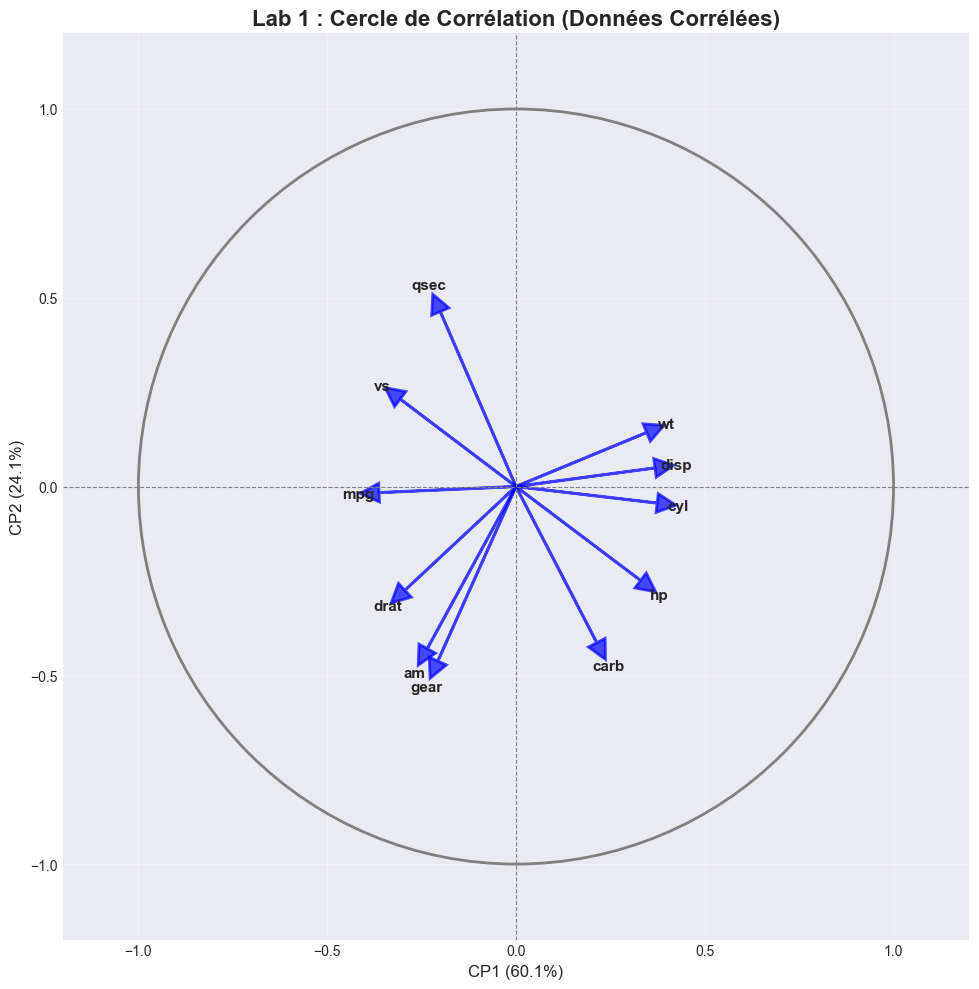

In [24]:
# Cercle de corrélation
plot_variables(pca, num_feat.columns, "Lab 1 : Cercle de Corrélation (Données Corrélées)")

The following table shows the **coordinates of each variable on the first two principal components (CP1 and CP2)**.  
These values are the **data behind the correlation circle**, indicating the direction and strength of each variable in the PCA space.

In [26]:
# pca.components_ shape: (n_components, n_features)
loadings = pd.DataFrame(
    pca.components_.T,                     # transpose to get features as rows
    columns=[f'CP{i+1}' for i in range(pca.n_components_)],
    index=num_feat.columns                 # your original variable names
)
loadings_2 = loadings[['CP1', 'CP2']]
loadings_2


,CP1,CP2
mpg,-0.362531,-0.016124
cyl,0.373916,-0.043744
disp,0.368185,0.049324
hp,0.330057,-0.248784
drat,-0.294151,-0.274694
wt,0.346103,0.143038
qsec,-0.200456,0.463375
vs,-0.306511,0.231647
am,-0.234943,-0.429418
gear,-0.206916,-0.462349


### Interpretation of Principal Components

**CP1 is mostly influenced by:**  
- Positive contributors: `cyl`, `disp`, `hp`, `wt` 
- Negative contributors: `mpg`, `drat`, `vs`, 
This means that CP1 represents the difference between **heavier, more powerful cars** and **lighter, more fuel-efficient cars**.  
  - High values on CP1 correspond to cars with **more cylinders, bigger engines, higher horsepower, heavier weight, and more carburetors**.  
  - Low values on CP1 correspond to cars with **higher fuel efficiency (mpg), higher rear axle ratio (drat), and straight engines (vs)**.


**CP2 is mostly influenced by:**  
- **Positive contributor:** `qsec` (quarter-mile time) → performance trait  
- **Negative contributors:** `gear` (number of gears) and `am` (transmission type), along with `hp` and `carb` → transmission and engine traits  
This means that CP2 reflects the differences between cars based on **performance** and **transmission/engine characteristics**.  
  - **High values on CP2** → cars with **longer quarter-mile times (`qsec`)**, indicating **slower performance**.  
  - **Low values on CP2** → cars with **manual transmission (`am`), more gears (`gear`), higher horsepower (`hp`), and more carburetors (`carb`)**, representing **faster, performance-oriented cars with stronger transmission/engine traits**.



# Step 5: Graph of Individuals

This graph visualizes the **cars (observations/individuals) projected onto the first two principal components (CP1 and CP2)**. It enables to :
- Show the **distribution of cars** in the reduced PCA space.  
- Identify **patterns, clusters, or outliers** based on their characteristics.  
- Helps understand which cars are **similar or different** according to the main sources of variation captured by CP1 and CP2.  

In [29]:
def plot_individus(X_pca, title="Graphe des Individus"):
    """
    Graphique des individus projetés sur les 2 premières composantes.
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    plt.xlabel(f'CP1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    plt.ylabel(f'CP2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


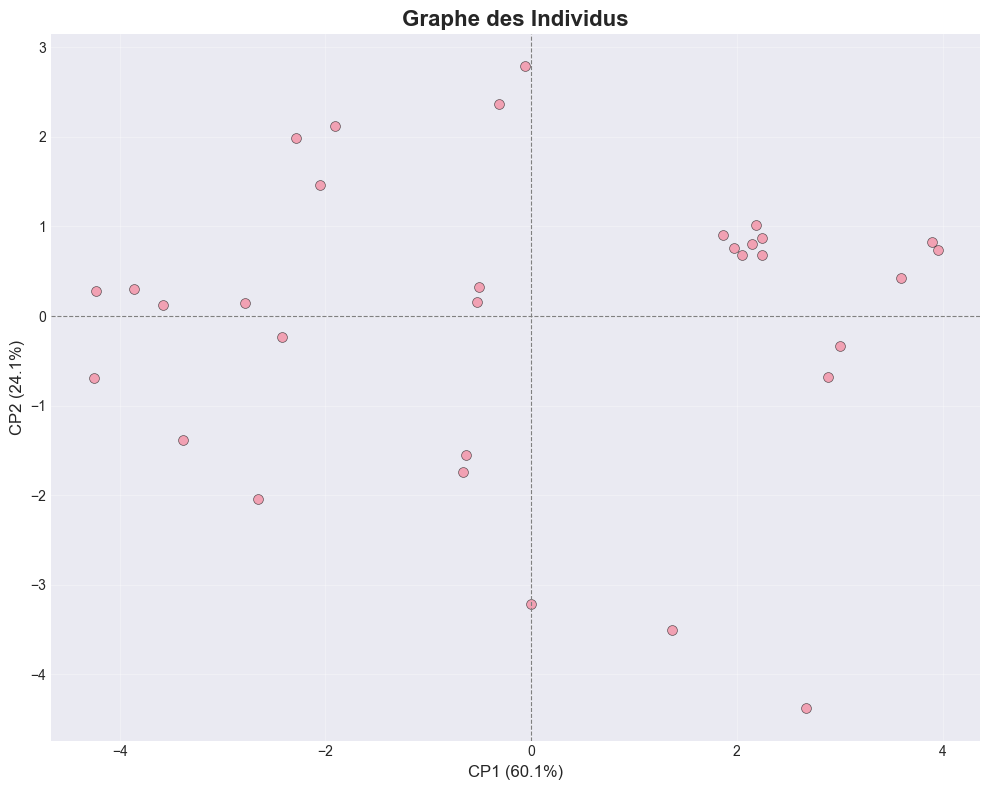

In [30]:
plot_individus(X_pca, "Graphe des Individus")

**Quadrant Interpretation:**  
- **Top-left (CP1−, CP2+) – 11 cars:** Lighter or more fuel-efficient cars with **slower performance**.  
- **Top-right (CP1+, CP2+) – 10 cars:** Heavier, more powerful cars with **slower performance**.  
- **Bottom-left (CP1−, CP2−) – 7 cars:** Lighter or fuel-efficient cars with **better performance and manual/stronger transmission traits**.  
- **Bottom-right (CP1+, CP2−) – 4 cars:** Heavier, more powerful cars with **better performance and manual/stronger transmission traits**.  

Overall, most cars have **slow performance**, while fewer are **powerful yet fast/performance-oriented vehicles**.


In [32]:

# Suppose you already have your PCA results
X_pca_df = pd.DataFrame(X_pca[:, :2], columns=['CP1', 'CP2'])

# Add quadrant information
def determine_quadrant(row):
    if row['CP1'] >= 0 and row['CP2'] >= 0:
        return 'Top-right (CP1+, CP2+)'
    elif row['CP1'] < 0 and row['CP2'] >= 0:
        return 'Top-left (CP1−, CP2+)'
    elif row['CP1'] >= 0 and row['CP2'] < 0:
        return 'Bottom-right (CP1+, CP2−)'
    else:
        return 'Bottom-left (CP1−, CP2−)'

X_pca_df['Quadrant'] = X_pca_df.apply(determine_quadrant, axis=1)

# Display the table
#X_pca_df
X_pca_df['Quadrant'].value_counts()

Quadrant
Top-left (CP1−, CP2+)        11
Top-right (CP1+, CP2+)       10
Bottom-left (CP1−, CP2−)      7
Bottom-right (CP1+, CP2−)     4
Name: count, dtype: int64

# Step 6: Dimensionality Reduction

To simplify our analysis and focus on the most important information, we reduce the dataset to the principal components that capture most of the variance.  
Here, we choose to keep only the **first 2 principal components (CP1 and CP2)**, which explain over 80% of the variance.


In [34]:
def reduce_dimensions(df, n_components=2):
    """
    Perform PCA on the dataset and return the reduced dataset with selected components.

    Parameters:
    df : pandas.DataFrame
        Original numerical dataset.
    n_components : int
        Number of principal components to keep.

    Returns:
    X_reduced : pandas.DataFrame
        Dataset projected onto the selected principal components.
    pca_model : PCA object
        The fitted PCA model (optional for further analysis).
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    # Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Convert to DataFrame with component names
    component_names = [f'CP{i+1}' for i in range(n_components)]
    X_reduced = pd.DataFrame(X_pca, columns=component_names, index=df.index)

    return X_reduced, pca


In [35]:
# select the number of components to keep
X_reduced, pca_model = reduce_dimensions(num_feat, n_components=2)

# Display the reduced dataset
X_reduced.head()

,CP1,CP2
0,-0.657213,-1.735446
1,-0.629396,-1.550033
2,-2.779397,0.146457
3,-0.311771,2.363019
4,1.974489,0.754402


### Reduced Dataset

The new dataset now contains only **CP1 and CP2**, representing the most important sources of variation in the original data.  
This reduced dataset can be used for **visualization, clustering, or further analysis** while maintaining most of the original information.